# Рефактор работы с моделью

In [1]:
from audiointerp.dataset.esc50 import ESC50dataset
from audiointerp.model.cnn14 import TransferCnn14
from audiointerp.fit import Trainer
from audiointerp.processing.spectrogram import LogMelSTFTSpectrogram, LogSTFTSpectrogram
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio.transforms as T_audio
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
root_dir = "/home/yuliya/ESC50"
sr = 32000
train_folds = [1, 2, 3]
valid_folds = [4]
test_folds = [5]

In [3]:
def plot_learning_curves(train_losses, val_losses, train_accs=None, val_accs=None):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    if val_losses:
        plt.plot(epochs, val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()

    plt.subplot(1, 2, 2)
    if train_accs is not None:
        plt.plot(epochs, train_accs, label="Train Acc")
    if val_accs is not None:
        plt.plot(epochs, val_accs, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curve")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [4]:
def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    
    with torch.no_grad():
        for samples, labels in test_loader:
            samples = samples.to(device)
            labels = labels.to(device)
            
            outputs = model(samples)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * samples.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += samples.size(0)
    
    test_loss = running_loss / total_samples
    test_acc = running_corrects.double() / total_samples

    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc.item():.4f}")
    
    return test_loss, test_acc.item()

## 1. Тесты на logmel

In [5]:
n_fft = 1024
hop_length = 320
win_length = 1024
n_mels = 64
f_min = 50
f_max = 14000
top_db = 80

In [6]:
feature_extractor_logmelstft = LogMelSTFTSpectrogram(
    n_fft=n_fft, win_length=win_length, hop_length=hop_length,
    sample_rate=sr, n_mels=n_mels, f_min=f_min, f_max=f_max, top_db=top_db,
    return_phase=False, return_full_db=False
)

In [7]:
feature_augs = nn.Sequential(
    T_audio.FrequencyMasking(20),
    T_audio.TimeMasking(20)
)

In [8]:
train_data = ESC50dataset(root_dir=root_dir, sr=sr, folds=train_folds, normalize="peak", feature_extractor=feature_extractor_logmelstft, feature_augs=feature_augs)
valid_data = ESC50dataset(root_dir=root_dir, sr=sr, folds=valid_folds, normalize="peak", feature_extractor=feature_extractor_logmelstft)
test_data = ESC50dataset(root_dir=root_dir, sr=sr, folds=test_folds, normalize="peak", feature_extractor=feature_extractor_logmelstft)

In [9]:
train_loader_kwargs = {"batch_size": 32, "shuffle": True}
valid_loader_kwargs = {"batch_size": 32, "shuffle": False}
test_loader_kwargs = {"batch_size": 32, "shuffle": False}

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_cls = TransferCnn14
model_kwargs = {"num_classes": 50, "num_bins": 64}
model_pretrain_weights_path = "weights/Cnn14_mAP=0.431.pth"

optimizer_cls = optim.Adam
optimizer_kwargs = {"lr": 1e-4}

criterion_cls = nn.CrossEntropyLoss
use_mixup = True
mixup_alpha = 0.2

In [11]:
model_trainer = Trainer(
    model_cls=model_cls,
    train_data=train_data,
    train_loader_kwargs=train_loader_kwargs,
    criterion_cls=criterion_cls,
    optimizer_cls=optimizer_cls,
    model_kwargs=model_kwargs,
    model_pretrain_weights_path=model_pretrain_weights_path,
    optimizer_kwargs=optimizer_kwargs,
    device=device,
    valid_data=valid_data,
    valid_loader_kwargs=valid_loader_kwargs,
    test_data=test_data,
    test_loader_kwargs=test_loader_kwargs,
    use_mixup=use_mixup,
    mixup_alpha=mixup_alpha
)

Random seed set to: 42


In [12]:
train_losses, train_accs, val_losses, val_accs, test_loss, test_acc = model_trainer.train(num_epochs=20, save_weights_path="test_ref.pth")

Epoch:   5%|▌         | 1/20 [01:01<19:22, 61.16s/it]

Train Loss: 3.8838, Train Acc: 0.0443
Valid Loss: 3.7438, Valid Acc: 0.1550


Epoch:  10%|█         | 2/20 [02:04<18:44, 62.48s/it]

Train Loss: 3.6654, Train Acc: 0.1361
Valid Loss: 3.3127, Valid Acc: 0.5200


Epoch:  15%|█▌        | 3/20 [03:06<17:39, 62.31s/it]

Train Loss: 3.0176, Train Acc: 0.3261
Valid Loss: 1.9327, Valid Acc: 0.7150


Epoch:  20%|██        | 4/20 [04:08<16:35, 62.23s/it]

Train Loss: 2.1878, Train Acc: 0.4690
Valid Loss: 0.9843, Valid Acc: 0.8175


Epoch:  25%|██▌       | 5/20 [05:11<15:33, 62.26s/it]

Train Loss: 1.6977, Train Acc: 0.5879
Valid Loss: 0.6061, Valid Acc: 0.8750


Epoch:  30%|███       | 6/20 [06:16<14:48, 63.46s/it]

Train Loss: 1.3186, Train Acc: 0.6975
Valid Loss: 0.4878, Valid Acc: 0.8950


Epoch:  35%|███▌      | 7/20 [07:19<13:39, 63.03s/it]

Train Loss: 1.2357, Train Acc: 0.7573
Valid Loss: 0.4353, Valid Acc: 0.9050


Epoch:  40%|████      | 8/20 [08:19<12:24, 62.07s/it]

Train Loss: 1.2417, Train Acc: 0.7562
Valid Loss: 0.4052, Valid Acc: 0.9150


Epoch:  45%|████▌     | 9/20 [09:20<11:21, 61.96s/it]

Train Loss: 0.9597, Train Acc: 0.8132
Valid Loss: 0.3229, Valid Acc: 0.9275


Epoch:  50%|█████     | 10/20 [10:24<10:24, 62.46s/it]

Train Loss: 1.1448, Train Acc: 0.7768
Valid Loss: 0.3407, Valid Acc: 0.9250


Epoch:  55%|█████▌    | 11/20 [11:25<09:18, 62.08s/it]

Train Loss: 1.1409, Train Acc: 0.7646
Valid Loss: 0.3313, Valid Acc: 0.9175


Epoch:  60%|██████    | 12/20 [12:26<08:13, 61.63s/it]

Train Loss: 0.9219, Train Acc: 0.8162
Valid Loss: 0.2994, Valid Acc: 0.9275


Epoch:  65%|██████▌   | 13/20 [13:26<07:09, 61.34s/it]

Train Loss: 0.8704, Train Acc: 0.8341
Valid Loss: 0.2904, Valid Acc: 0.9300


Epoch:  70%|███████   | 14/20 [14:27<06:06, 61.08s/it]

Train Loss: 0.9663, Train Acc: 0.8240
Valid Loss: 0.2938, Valid Acc: 0.9225


Epoch:  75%|███████▌  | 15/20 [15:27<05:04, 60.96s/it]

Train Loss: 0.9562, Train Acc: 0.8280
Valid Loss: 0.2881, Valid Acc: 0.9275


Epoch:  80%|████████  | 16/20 [16:32<04:07, 61.89s/it]

Train Loss: 0.8694, Train Acc: 0.8397
Valid Loss: 0.2982, Valid Acc: 0.9300


Epoch:  85%|████████▌ | 17/20 [17:34<03:05, 61.99s/it]

Train Loss: 0.9712, Train Acc: 0.8397
Valid Loss: 0.3077, Valid Acc: 0.9350


Epoch:  90%|█████████ | 18/20 [18:37<02:04, 62.33s/it]

Train Loss: 0.8365, Train Acc: 0.8515
Valid Loss: 0.2787, Valid Acc: 0.9300


Epoch:  95%|█████████▌| 19/20 [19:43<01:03, 63.46s/it]

Train Loss: 1.1698, Train Acc: 0.7815
Valid Loss: 0.3075, Valid Acc: 0.9300


Epoch: 100%|██████████| 20/20 [20:44<00:00, 62.25s/it]


Train Loss: 0.8988, Train Acc: 0.8353
Valid Loss: 0.2837, Valid Acc: 0.9325
Best val Acc: 0.9350
Модель сохранена в test_ref.pth
Test Loss: 0.3285, Test Acc: 0.9175


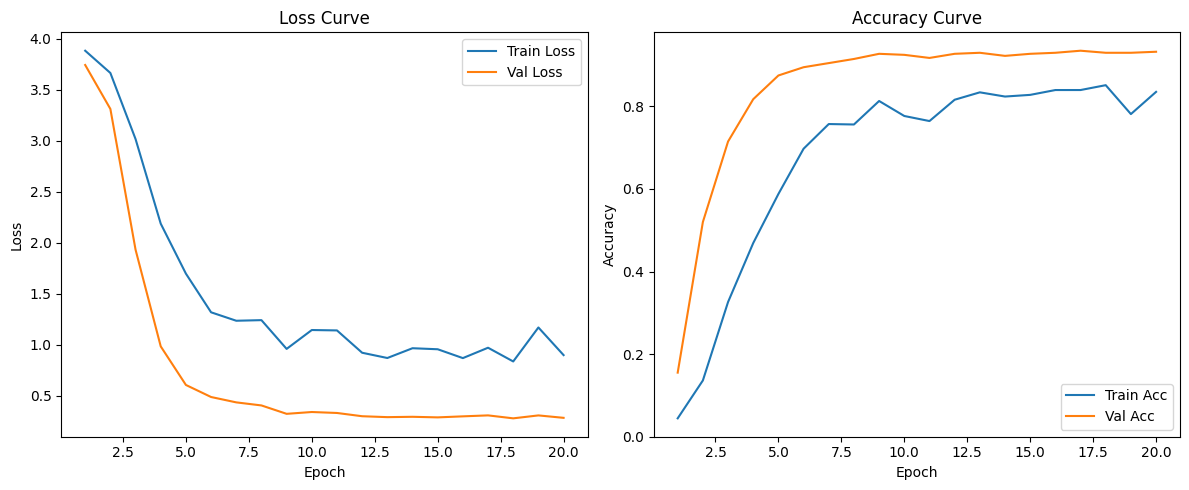

In [13]:
plot_learning_curves(train_losses=train_losses, train_accs=train_accs, val_losses=val_losses, val_accs=val_accs)

In [14]:
model = TransferCnn14(**model_kwargs)
model.load_state_dict(torch.load("test_ref.pth"))
model.to(device)

TransferCnn14(
  (base): Cnn14(
    (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_block1): ConvBlock(
      (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv_block2): ConvBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv_block3): ConvBlock(
      (conv1): Conv2d(128, 

In [15]:
# тест загрузки
test_loader = DataLoader(test_data, **test_loader_kwargs)
test_loss, test_acc = test(model, test_loader, criterion_cls(), device)

Test Loss: 0.3285, Test Acc: 0.9175


## 2. Тесты на log-stft

In [16]:
feature_extractor_logstft = LogMelSTFTSpectrogram(
    n_fft=n_fft, win_length=win_length, hop_length=hop_length,
    return_phase=False, return_full_db=False
)

In [17]:
train_data = ESC50dataset(root_dir=root_dir, sr=sr, folds=train_folds, normalize="peak", feature_extractor=feature_extractor_logstft, feature_augs=feature_augs)
valid_data = ESC50dataset(root_dir=root_dir, sr=sr, folds=valid_folds, normalize="peak", feature_extractor=feature_extractor_logstft)
test_data = ESC50dataset(root_dir=root_dir, sr=sr, folds=test_folds, normalize="peak", feature_extractor=feature_extractor_logstft)

In [18]:
model_kwargs = {"num_classes": 50, "num_bins": 80}

In [19]:
model_trainer = Trainer(
    model_cls=model_cls,
    train_data=train_data,
    train_loader_kwargs=train_loader_kwargs,
    criterion_cls=criterion_cls,
    optimizer_cls=optimizer_cls,
    model_kwargs=model_kwargs,
    model_pretrain_weights_path=model_pretrain_weights_path,
    optimizer_kwargs=optimizer_kwargs,
    device=device,
    valid_data=valid_data,
    valid_loader_kwargs=valid_loader_kwargs,
    test_data=test_data,
    test_loader_kwargs=test_loader_kwargs,
    use_mixup=use_mixup,
    mixup_alpha=mixup_alpha
)

Random seed set to: 42


In [20]:
train_losses, train_accs, val_losses, val_accs, test_loss, test_acc = model_trainer.train(num_epochs=5, save_weights_path="test_ref_logstft.pth")

Epoch:  20%|██        | 1/5 [02:44<10:57, 164.39s/it]

Train Loss: 3.9011, Train Acc: 0.0297
Valid Loss: 3.7538, Valid Acc: 0.1200


Epoch:  40%|████      | 2/5 [05:29<08:14, 164.79s/it]

Train Loss: 3.6650, Train Acc: 0.1210
Valid Loss: 3.3728, Valid Acc: 0.4900


Epoch:  60%|██████    | 3/5 [08:08<05:24, 162.10s/it]

Train Loss: 3.0903, Train Acc: 0.2833
Valid Loss: 2.1623, Valid Acc: 0.6975


Epoch:  80%|████████  | 4/5 [10:43<02:39, 159.32s/it]

Train Loss: 2.2984, Train Acc: 0.4498
Valid Loss: 1.1459, Valid Acc: 0.8000


Epoch: 100%|██████████| 5/5 [13:13<00:00, 158.62s/it]


Train Loss: 1.7368, Train Acc: 0.5720
Valid Loss: 0.6780, Valid Acc: 0.8775
Best val Acc: 0.8775
Модель сохранена в test_ref_logstft.pth
Test Loss: 0.7244, Test Acc: 0.8425


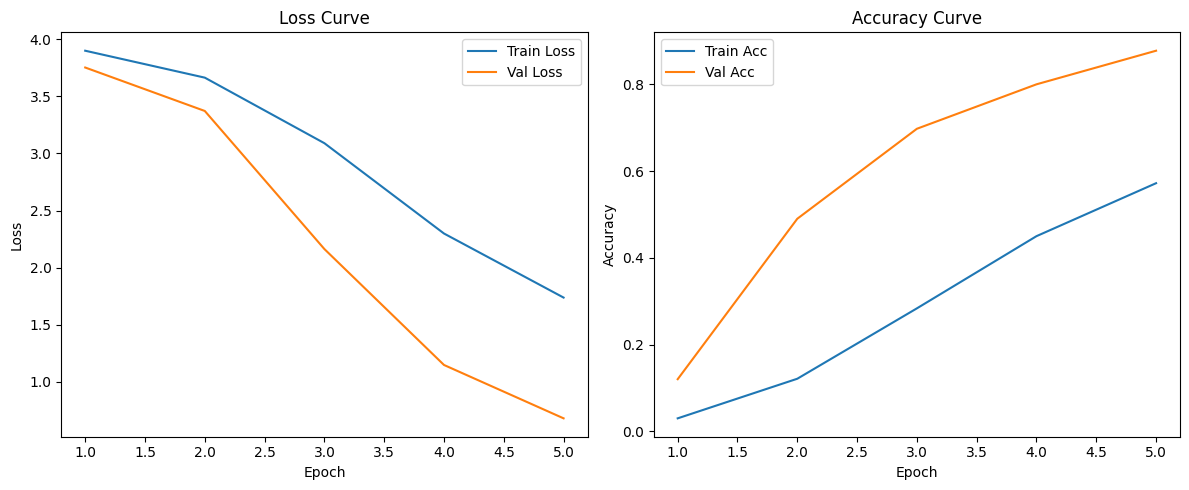

In [21]:
plot_learning_curves(train_losses=train_losses, train_accs=train_accs, val_losses=val_losses, val_accs=val_accs)

In [22]:
model = TransferCnn14(**model_kwargs)
model.load_state_dict(torch.load("test_ref_logstft.pth"))
model.to(device)

TransferCnn14(
  (base): Cnn14(
    (bn0): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_block1): ConvBlock(
      (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv_block2): ConvBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv_block3): ConvBlock(
      (conv1): Conv2d(128, 

In [23]:
# тест загрузки
test_loader = DataLoader(test_data, **test_loader_kwargs)
test_loss, test_acc = test(model, test_loader, criterion_cls(), device)

Test Loss: 0.7244, Test Acc: 0.8425
